In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [66]:
df = pd.read_csv('./data/KAG_energydata_complete.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [67]:
df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

As seen above, there are no null values in the dataset.

We will remove the 'date' column as it is not needed for our analysis. Having a dataset with temperature, humidity, and other features is sufficient for our energy prediction task.

In [68]:
df = df.drop(columns=['date'])
corr_matrix = df.corr()

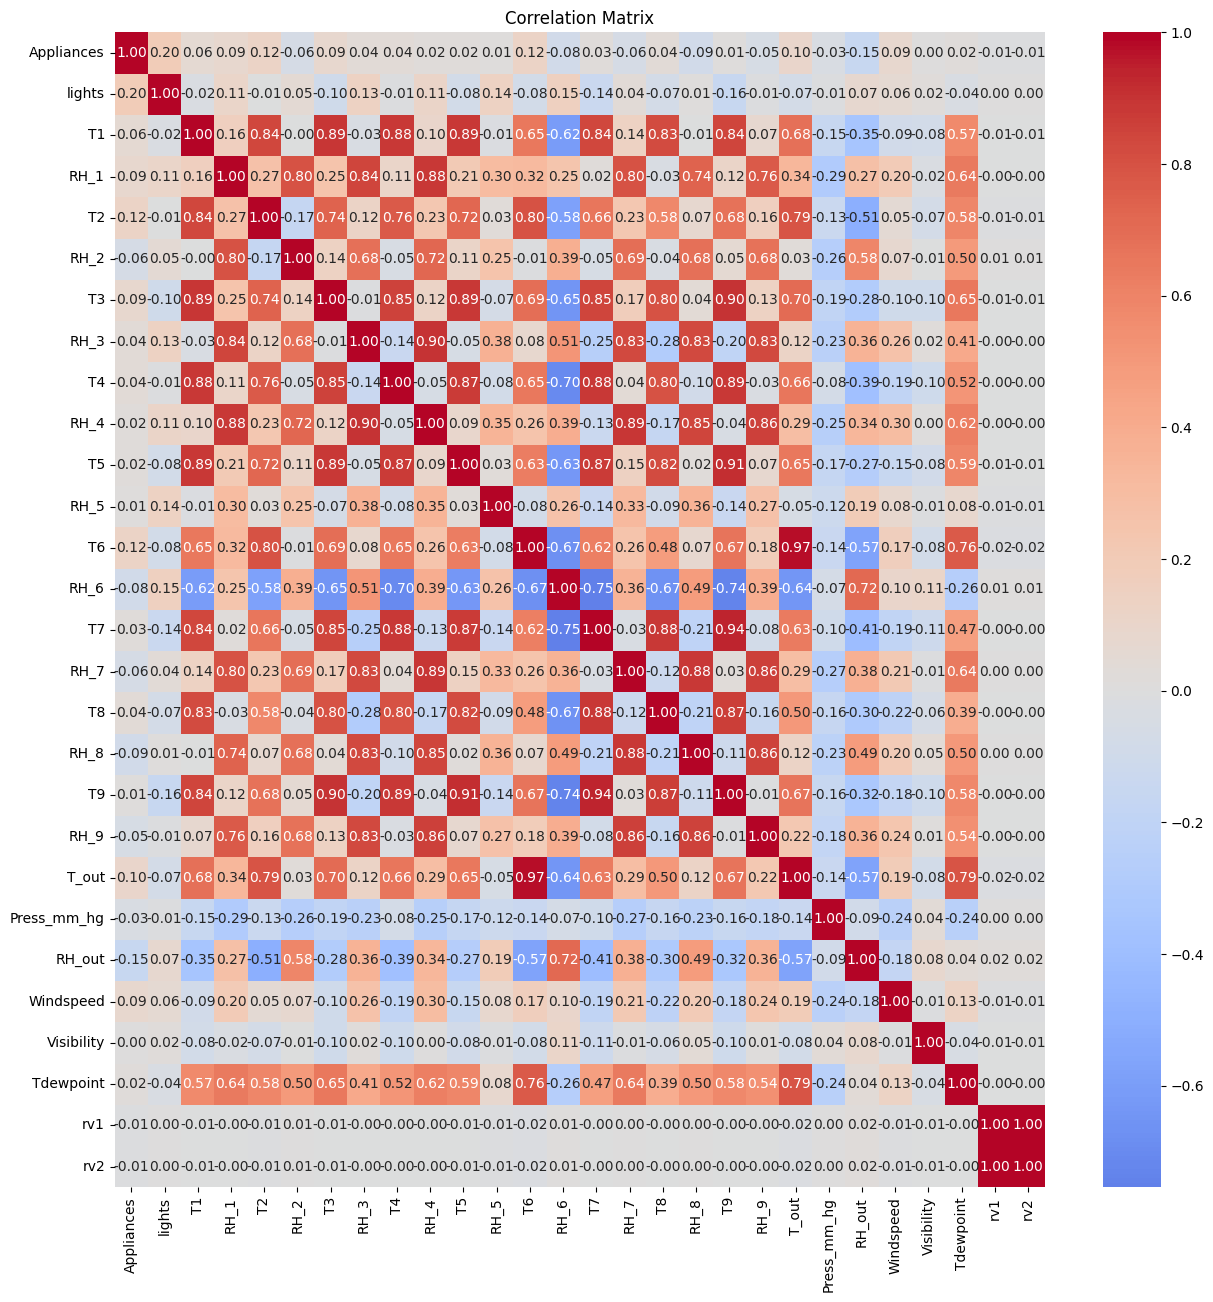

In [69]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

In [70]:
def get_redundant_pairs(data_frame):
    pairs_to_drop = set()
    cols = data_frame.columns
    for i in range(0, data_frame.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(data_frame, n=100):
    au_corr = data_frame.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(data_frame)
    au_corr = au_corr.drop(labels=labels_to_drop)
    sorted_corr = au_corr.sort_values(ascending=False)
    return sorted_corr[:n]


get_top_abs_correlations(df, 40)

rv1   rv2      1.000000
T6    T_out    0.974787
T7    T9       0.944776
T5    T9       0.911055
T3    T9       0.901324
RH_3  RH_4     0.898978
RH_4  RH_7     0.894301
T1    T3       0.892402
T4    T9       0.889439
T3    T5       0.888169
T1    T5       0.885247
RH_7  RH_8     0.883984
T7    T8       0.882123
RH_1  RH_4     0.880359
T4    T7       0.877763
T1    T4       0.877001
T4    T5       0.871813
T5    T7       0.870624
T8    T9       0.869338
RH_7  RH_9     0.858686
RH_4  RH_9     0.856591
RH_8  RH_9     0.855812
T3    T4       0.852778
      T7       0.847374
RH_4  RH_8     0.847259
T1    T9       0.844777
RH_1  RH_3     0.844677
T1    T7       0.838705
      T2       0.836834
RH_3  RH_9     0.833538
      RH_7     0.832685
      RH_8     0.828822
T1    T8       0.825413
T5    T8       0.824981
T2    T6       0.801186
RH_1  RH_7     0.801122
      RH_2     0.797535
T4    T8       0.796256
T3    T8       0.795283
T2    T_out    0.792255
dtype: float64

As we notice from the correlation matrix three rooms are highly correlated to room 'T9', so that we can drop it from the dataset. Both 'T6' and 'T_out' represents external temperature, indeed, they are highly correlated. We will drop 'T6' as well.

In [71]:
df.drop(columns=['T9', 'T6', 'rv1', 'rv2'], inplace=True)
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_7,T8,RH_8,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,41.626667,18.2,48.900000,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,41.560000,18.2,48.863333,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,41.433333,18.2,48.730000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,41.290000,18.1,48.590000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,41.230000,18.1,48.590000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


Now we are ready to split the dataset into training and testing sets. We will use 80% of the data for training and 20% for testing.

In [72]:
train_X, test_X, train_y, test_y = train_test_split(df.drop(columns=['Appliances']), df['Appliances'], test_size=0.2,
                                                    random_state=42)

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sc_train_X = scaler.fit_transform(train_X)
sc_test_X = scaler.transform(test_X)

In [74]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


def evaluate_model(m, x_train, y_train, x_test, y_test):
    m.fit(x_train, y_train)
    y_pred = m.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}")
    print()


models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
    "Support Vector Regressor": SVR(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Extra Trees Regressor": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42, early_stopping=True),
}

for name, model in models.items():
    print("=" * 20)
    print(f"{name}:")
    evaluate_model(model, sc_train_X, train_y, sc_test_X, test_y)

Linear Regression:
RMSE: 91.63
R²:   0.1611

Ridge Regression:
RMSE: 91.62
R²:   0.1611

Lasso Regression:
RMSE: 92.27
R²:   0.1493

ElasticNet Regression:
RMSE: 94.60
R²:   0.1057

Support Vector Regressor:
RMSE: 98.35
R²:   0.0334

Random Forest Regressor:
RMSE: 68.38
R²:   0.5327

Gradient Boosting Regressor:
RMSE: 85.73
R²:   0.2655

Extra Trees Regressor:
RMSE: 62.66
R²:   0.6077

MLP Regressor:
RMSE: 87.53
R²:   0.2344



Between all the models used the Extra Trees Regressor has the best r2 and RMSE. We can use this model for our energy prediction task.

# Parameter Tuning

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 80, 150, 200, 250],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(ExtraTreesRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=2)
grid_search.fit(sc_train_X, train_y)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 90 candidates, totalling 270 fits


In [76]:
pred_y = best_model.predict(sc_test_X)
mse = mean_squared_error(test_y, pred_y)
mae = mean_absolute_error(test_y, pred_y)
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f"R²: {r2_score(test_y, pred_y):.4f}")
print(grid_search.best_params_)

MAE: 26.5310
MSE: 3402.7373
RMSE: 58.3330
R²: 0.6600
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}


## Observations

1. The best parameters for the Extra Trees Regressor are: 'max_depth': None, max_features': 'sqrt', min_samples_split': 2, 'n_estimators': 300.
2. The model has an RMSE of 60.486 which indicates an improvement over 63.77 achieved using untuned model.
3. The R² score is 0.634, over 0.593 achieved using untuned model.